<a href="https://colab.research.google.com/github/X-Xin6/DeLIVR/blob/main/Stage2_model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Function definition
def g(x):
    return 3 * x**2

# Generate x values
x = np.linspace(-10, 10, 10000)

# Confounder variable U (e.g., normal distribution with mean 0 and std deviation 5)
U = np.random.normal(0, 5, 10000)

# Generate y values
y = g(x) + U

# Create a DataFrame for the dataset
data = pd.DataFrame({'x': x, 'y': y})

# Display the first few rows of the dataset
print(data.head())


           x           y
0 -10.000000  309.838223
1  -9.998000  302.423552
2  -9.996000  295.254913
3  -9.993999  297.090359
4  -9.991999  300.146944


In [2]:
def standardize_data(X):
    """
    Standardize the dataset X.
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

# Simulate data for two-stage experiment
def generate_data(IV, beta, true_g, gamma, seed = 0):
	#seed for reproducibility
	if seed is None:
		seed = np.random.randint(0,2**32 - 1)
	np.random.seed(seed)
 #select 10% for first-stage sample
	s1_size = IV.shape[0]//10
	#The indices for stage 1 and stage 2
	s1_idx = np.random.choice(np.arange(IV.shape[0]), size = s1_size, replace = False)
	s2_idx = np.array(list(set(np.arange(IV.shape[0])).difference(s1_idx)))
	# stage 1 data and stage2 data
	s1_IV = IV[s1_idx,:]
	s2_IV = IV[s2_idx,:]
	#X=z*beta + error 1
	s1_expr = (s1_IV@beta).squeeze() + np.random.normal(size = s1_size)
	s1_expr = s1_expr.reshape(-1,1)
 # The Correlation Representing Confounding
	e = np.random.multivariate_normal(mean = [0,0], cov = [[1,gamma],[gamma,1]], size = s2_IV.shape[0])
  #s2_expr=s2_IV⋅β+e:,0
	s2_expr = (s2_IV@beta).squeeze() + e[:,0]
	#Y=s2_pheno=true_g(s2_expr)+e:,1
	s2_pheno = true_g(s2_expr) + e[:,1]
	s2_expr = s2_expr.reshape(-1,1)

	return s1_IV, s1_expr, s2_IV, s2_pheno

In [3]:
import torch
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from torch import nn, optim
#data simulation test
#Data Simulation
# Load data



In [4]:
import torch
from torch import nn

class Stage2Model(nn.Module):
    def __init__(self):
        super(Stage2Model, self).__init__()

        # Define the first part of the network
        self.dense1 = nn.Linear(in_features=1, out_features=8)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(in_features=8, out_features=8)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(in_features=8, out_features=1)

        # Define the skip connection
        self.skip_dense = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        # Forward pass through the first part of the network
        x1 = self.dense1(x)
        x1 = self.relu1(x1)
        x1 = self.dense2(x1)
        x1 = self.relu2(x1)
        x1 = self.dense3(x1)

        # Forward pass through the skip connection
        skip_out = self.skip_dense(x)

        # Add the output of the skip connection to the main network's output
        x1 += skip_out

        return x1

# Instantiate the model
stage2_model = Stage2Model()

# Print the model architecture
print(stage2_model)



Stage2Model(
  (dense1): Linear(in_features=1, out_features=8, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=8, out_features=1, bias=True)
  (skip_dense): Linear(in_features=1, out_features=1, bias=True)
)


In [5]:
def sample_split(expr, pheno, test_ratio, val_ratio, seed=None):
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)

    # Split the data into training and validation + test sets
    expr_train, expr_temp, pheno_train, pheno_temp = \
        train_test_split(expr, pheno, test_size=val_ratio + test_ratio, random_state=seed)

    # Calculate the proportion of the test set relative to the combined validation and test sets
    test_ratio_adjusted = test_ratio / (val_ratio + test_ratio)

    # Split the validation + test sets into separate validation and test sets
    expr_val, expr_test, pheno_val, pheno_test = \
        train_test_split(expr_temp, pheno_temp, test_size=test_ratio_adjusted, random_state=seed)

    return expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test


import torch.optim as optim

def train_stage2(model, X_train, y_train, X_val, y_val, epochs, learning_rate,weight_decay):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    train_losses, val_losses = [], []

    # Reshape the input tensors to have two dimensions: [batch_size, num_features]
    X_train = X_train.view(-1, 1) if len(X_train.shape) == 1 else X_train
    X_val = X_val.view(-1, 1) if len(X_val.shape) == 1 else X_val

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    return train_losses, val_losses


In [6]:
    test_ratio = 0.4
    val_ratio = 0.1

    expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test = sample_split(x, y, test_ratio, val_ratio)
    print(np.shape(expr_train))
    # Reshape the data
    expr_train_reshaped = expr_train.reshape(-1, 1)  # Reshape for PyTorch
    expr_val_reshaped = expr_val.reshape(-1, 1)
    expr_test_reshaped = expr_test.reshape(-1, 1)
    pheno_train, pheno_val, pheno_test
    pheno_train_reshaped = pheno_train.reshape(-1, 1)  # Reshape for PyTorch
    pheno_val_reshaped = pheno_val.reshape(-1, 1)
    pheno_test_reshaped = pheno_test.reshape(-1, 1)

    # Convert to PyTorch tensors
    expr_train_tensor = torch.tensor(expr_train_reshaped, dtype=torch.float32)
    expr_val_tensor = torch.tensor(expr_val_reshaped, dtype=torch.float32)
    expr_test_tensor = torch.tensor(expr_test_reshaped, dtype=torch.float32)
    pheno_train_tensor = torch.tensor(pheno_train_reshaped, dtype=torch.float32)
    pheno_val_tensor = torch.tensor(pheno_val_reshaped, dtype=torch.float32)
    pheno_test_tensor = torch.tensor(pheno_test_reshaped, dtype=torch.float32)


    stage2_model = Stage2Model()
    #np.shape(expr_train_tensor.shape[1])
    #print(expr_train_tensor.shape)
    #train_stage2(stage2_model, expr_train_tensor, pheno_train_tensor, None, None)  # Assuming no validation set for simplicity
    import matplotlib.pyplot as plt

# Assuming 'train_losses' and 'val_losses' are obtained from the training function
    train_losses, val_losses = train_stage2(stage2_model, expr_train_tensor, pheno_train_tensor,expr_val_tensor,  pheno_val_tensor,  epochs=10000, learning_rate=0.003,weight_decay=0.01)

(5000,)
Epoch 1/10000, Train Loss: 18228.455078125, Val Loss: 17659.103515625
Epoch 51/10000, Train Loss: 17586.275390625, Val Loss: 17003.9765625
Epoch 101/10000, Train Loss: 14516.75390625, Val Loss: 13918.7421875
Epoch 151/10000, Train Loss: 7944.8154296875, Val Loss: 7464.54296875
Epoch 201/10000, Train Loss: 2548.235107421875, Val Loss: 2392.388427734375
Epoch 251/10000, Train Loss: 1617.0057373046875, Val Loss: 1609.16748046875
Epoch 301/10000, Train Loss: 1521.1297607421875, Val Loss: 1515.8946533203125
Epoch 351/10000, Train Loss: 1428.67919921875, Val Loss: 1428.0577392578125
Epoch 401/10000, Train Loss: 1330.1864013671875, Val Loss: 1331.2156982421875
Epoch 451/10000, Train Loss: 1231.5087890625, Val Loss: 1233.8675537109375
Epoch 501/10000, Train Loss: 1132.9599609375, Val Loss: 1136.25927734375
Epoch 551/10000, Train Loss: 1022.6494140625, Val Loss: 1025.6903076171875
Epoch 601/10000, Train Loss: 874.9459228515625, Val Loss: 878.7669677734375
Epoch 651/10000, Train Loss: 71

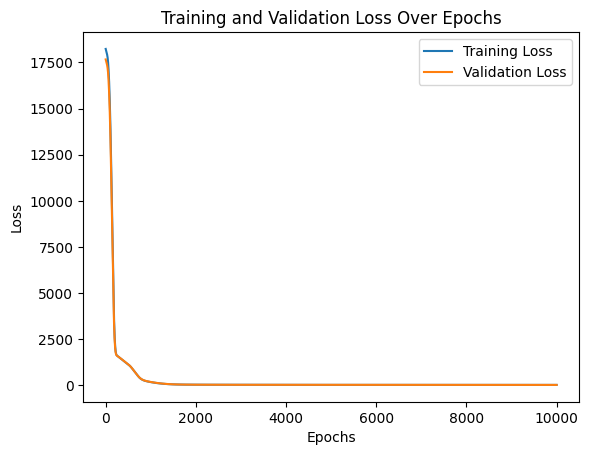

In [7]:
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

MSE: 15976.8525390625, RMSE: 126.39957427978516, MAE: 100.19388580322266


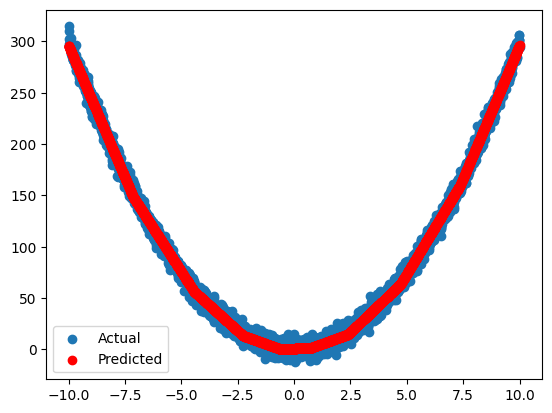

array([[  8.134729],
       [ 46.972145],
       [ 92.48713 ],
       ...,
       [ 96.02492 ],
       [ 33.623657],
       [141.96625 ]], dtype=float32)

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming expr_test_tensor and pheno_test_tensor are your test datasets

# Make predictions
stage2_model.eval()
with torch.no_grad():
    predictions = stage2_model(expr_test_tensor).squeeze()

# Convert predictions and actual values to NumPy for evaluation
predictions_np = predictions.numpy()
actual_np = pheno_test_tensor.numpy()

# Calculate MSE and other metrics
mse = np.mean((predictions_np - actual_np) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_np - actual_np))

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

# Plot predictions vs actual values
plt.scatter(expr_test_tensor.numpy(), actual_np, label="Actual")
plt.scatter(expr_test_tensor.numpy(), predictions_np, label="Predicted", color="r")
plt.legend()
plt.show()

actual_np

